## Neural translation model

Create a neural network that translates from English to German. Building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

In [59]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image
# for splitting sentences 
import re
# for finding random samples
import random
from tensorflow.keras.layers import Layer, concatenate, Input, Masking, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

Use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. 

#### Import the data


In [61]:
# load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [62]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

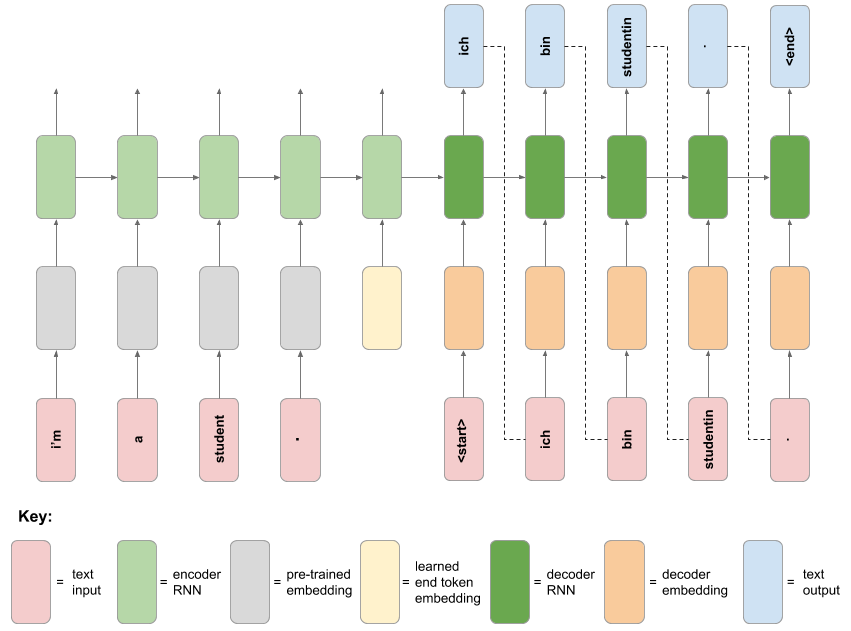

In [63]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model


The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [64]:
# create seperate lists for english and german
english_sentences = []
german_sentences = []
# characters to note end of sentence
sentenceEnders = re.compile('[.!?]')
# loop through each setence. 
# The first part is english, so append to english list
# The second part is german, so append to german list
for sentence in data_examples:
  seperated_sentence = sentenceEnders.split(sentence)
  english_sentences.append(preprocess_sentence(seperated_sentence[0]))
  german_sentence = "<start> " + preprocess_sentence(seperated_sentence[1]) + " <end>"
  german_sentences.append(german_sentence)


In [65]:

def max_len_finder(input_list):
  """Get max length in list
  """
  max_length = 0
  for item in input_list:
    curr_len = len(item) 
    if max_length < curr_len:
      max_length = curr_len
  return max_length

In [66]:
def tokenize_german_sentences(german_sentences):
  """Creates list and numpy array of tokenized sequence of german sentences 
  """
  # tokenize the German sentences 
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(german_sentences)
  german_sequences = tokenizer.texts_to_sequences(german_sentences)
  # get the vocab size 
  vocab_size = max(tokenizer.word_index.values()) + 1
  # Pad the inputs to the maximum length using maxlen
  max_len = max_len_finder(german_sequences)
  # create numpy array with padded sequences
  padded_german_sequences = tf.keras.preprocessing.sequence.pad_sequences(german_sequences, 
                                                                          maxlen=max_len,
                                                                          padding='post',
                                                                          truncating='post')

  return german_sequences, padded_german_sequences, vocab_size, tokenizer


In [67]:
def print_random_samples(english_sentences, german_sentences, padded_german_sequences):
  """Prints 5 randomly chosen setences from english_sentences, german_sentences, padded_german_sequences
  """
  minimum_sized_array = min([len(english_sentences), len(german_sentences)])
  for i in range(5):
    # get random index
    rand_index = random.randint(0,minimum_sized_array-1)
    print("English sentence: ", english_sentences[rand_index])
    print("German sentence: ", german_sentences[rand_index])
    print("German Sequence: ", padded_german_sequences[rand_index])

In [68]:
# get tokenized sequence 
german_sequences, padded_german_sequences, vocab_size, tokenizer = tokenize_german_sentences(german_sentences)
# print random sentences 
print_random_samples(english_sentences, german_sentences, padded_german_sequences)

English sentence:  did you read them
German sentence:  <start> hast du sie gelesen <end>
German Sequence:  [   1   55   10    6 1168    2    0    0    0    0    0    0    0]
English sentence:  i need minutes
German sentence:  <start> ich brauche dreissig minuten <end>
German Sequence:  [   1    3   91  491 5657    2    0    0    0    0    0    0    0]
English sentence:  i hate interviews
German sentence:  <start> ich hasse interviews <end>
German Sequence:  [   1    3  119 5621    2    0    0    0    0    0    0    0    0]
English sentence:  i was not drunk
German sentence:  <start> ich war nicht betrunken <end>
German Sequence:  [  1   3  21   9 287   2   0   0   0   0   0   0   0]
English sentence:  study more
German sentence:  <start> lern mehr <end>
German Sequence:  [   1 3272  141    2    0    0    0    0    0    0    0    0    0]


## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project,use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [69]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [70]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

Prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method.
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method.
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [71]:
def split_english_sentence_at_spaces(sentence, german_sequence):
  '''Split the input sentence into array of individual words
  '''
  split_sentence = tf.strings.split(sentence, sep=' ')
  return (split_sentence, german_sequence)


In [72]:
def embed_english_sequence(english_word_list, german_sequence):
  """Embeds each sequence of English words using the loaded embedding layer
  """
  embedded_sentance = embedding_layer(english_word_list)
  return (embedded_sentance, german_sequence)


In [73]:
def filter_english_embedded_tokens(embeded_english, german_sequnce):
  '''Filter out english sentences that are greater than or equal to 13 embedded tokens
  '''
  return len(embeded_english) <= 13



In [74]:
def pad_english_sequence(embeded_english, german_sequnce):
  """Pads each English sequence of embeddings with some distinct padding value 
     before the sequence, so that each sequence is length 13
  """
  pad_value = tf.constant([[13,0], [0,0]])
  embeded_english_padded = tf.pad(embeded_english, pad_value) 
  return (embeded_english_padded[-13:,:], german_sequnce)

In [75]:
def print_ds(ds):
  x = 0
  for item in ds: 
    if x > 20:
      break
    print(item)
    x = x+1
  return

In [90]:
# split training data into trianing/validation split 
split = int(len(english_sentences) *.8)
train_english_sentences = english_sentences[0:split]
val_english_sentences = english_sentences[split:]
train_german_padded_sequences = padded_german_sequences[0:split]
val_german_padded_sequences = padded_german_sequences[split:]
# load the training and validation sets into a Datset object 
train_dataset = tf.data.Dataset.from_tensor_slices((train_english_sentences, train_german_padded_sequences))
val_dataset = tf.data.Dataset.from_tensor_slices((val_english_sentences, val_german_padded_sequences))
# split each english sentence at spaces 
train_dataset = train_dataset.map(split_english_sentence_at_spaces)
val_dataset = val_dataset.map(split_english_sentence_at_spaces)
# embed english sequence
train_dataset = train_dataset.map(embed_english_sequence)
val_dataset = val_dataset.map(embed_english_sequence)
# filter out english sentences that are greater than or equal to 13 embedded tokens 
train_dataset = train_dataset.filter(filter_english_embedded_tokens)
val_dataset = val_dataset.filter(filter_english_embedded_tokens)
# pad the english sequence
train_dataset = train_dataset.map(pad_english_sequence)
val_dataset = val_dataset.map(pad_english_sequence)
# batch size = 16
BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
# print element spec for both train and validation
train_dataset.element_spec
val_dataset.element_spec
# get the shape for a padded english example in the train dataset
for english_train_example, german_train_example in train_dataset.take(1):
  print("Shape of English Training Example: ", english_train_example.shape)
  print(german_train_example)
# get the shape for a german sequence example in the validation dataset
for english_val_example, german_val_example in val_dataset.take(1):
  print("Shape of German Validation Example: ", german_val_example.shape)
  print(german_val_example)

Shape of English Training Example:  (16, 13, 128)
tf.Tensor(
[[   1  402    2    0    0    0    0    0    0    0    0    0    0]
 [   1 3156  659    2    0    0    0    0    0    0    0    0    0]
 [   1  971    2    0    0    0    0    0    0    0    0    0    0]
 [   1 3157    2    0    0    0    0    0    0    0    0    0    0]
 [   1 3158    2    0    0    0    0    0    0    0    0    0    0]
 [   1 1223    2    0    0    0    0    0    0    0    0    0    0]
 [   1  279    2    0    0    0    0    0    0    0    0    0    0]
 [   1   17 3159    2    0    0    0    0    0    0    0    0    0]
 [   1 2260    2    0    0    0    0    0    0    0    0    0    0]
 [   1  331    2    0    0    0    0    0    0    0    0    0    0]
 [   1   76  123    2    0    0    0    0    0    0    0    0    0]
 [   1  402    2    0    0    0    0    0    0    0    0    0    0]
 [   1    3  355    2    0    0    0    0    0    0    0    0    0]
 [   1    3  332    2    0    0    0    0    0    0    

## 3. Create the custom layer
Create a custom layer to add the learned end token embedding to the encoder model

![Encoder schematic](data/neural_translation_model_encoder.png)

Build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space).
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [78]:
class AddLearnedEmbeddedEndTokenLayer(Layer):
  def __init__(self, **kwargs):
    super(AddLearnedEmbeddedEndTokenLayer, self).__init__(**kwargs)
    self.token_embed = tf.Variable(initial_value=tf.random.uniform(shape=(128,)), 
                                   trainable=True)
  def call(self, inputs):
    token_embed_altered = tf.reshape(self.token_embed, (1,1,128))
    input_shape = tf.shape(inputs)
    end_embed_token = tf.tile(token_embed_altered, [input_shape[0], 1, 1])
    concat_input = concatenate([inputs, end_embed_token], axis=1)
    return concat_input

In [79]:
for english, german in train_dataset.take(1):
  print(f"initial english shape: {english.shape}")
  result = AddLearnedEmbeddedEndTokenLayer()(english)
  print(f"After Learned Embedded Layer: {result.shape}")

initial english shape: (16, 13, 128)
After Learned Embedded Layer: (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. Build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [80]:
def create_encoder_network(input_shape):
  '''Create the encoder nework model
  '''
  inputs = Input(shape=input_shape)
  embed_end_token = AddLearnedEmbeddedEndTokenLayer()(inputs)
  masking_layer = Masking(mask_value=-1)(embed_end_token)
  lstm, hidden, cell_states = LSTM(512, return_state=True)(masking_layer)
  model = Model(inputs=inputs, outputs=[hidden, cell_states])
  return model

In [81]:
# create the encoder model
encoder_model = create_encoder_network(input_shape=(13,128))
for english, german in train_dataset.take(1):
  hidden, cell_state = encoder_model(english)
  print(hidden.shape)
  print(cell_state.shape)
# model summary 
encoder_model.summary()

(16, 512)
(16, 512)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
add_learned_embedded_end_tok (None, 14, 128)           128       
_________________________________________________________________
masking_1 (Masking)          (None, 14, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

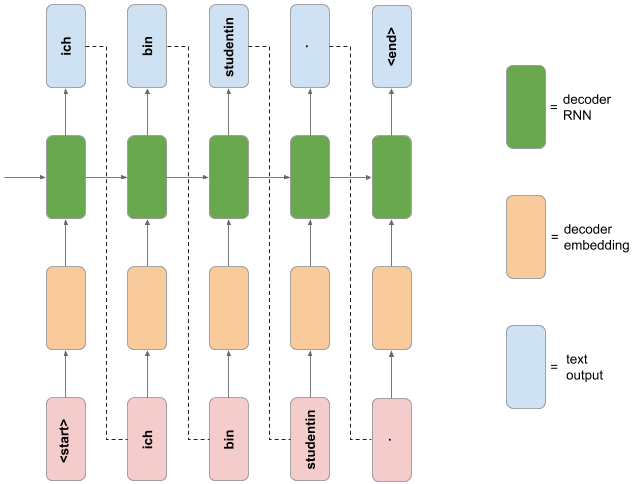

In [82]:
# Download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

Build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer.
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [83]:
class DecoderModel(Model):
  def __init__(self):
    super(DecoderModel, self).__init__()
    self.embedding_layer = Embedding(vocab_size, 128, mask_zero=True)
    self.lstm_layer = LSTM(512, return_sequences=True, return_state=True)
    self.dense = Dense(vocab_size)
  def call(self, inputs, hidden_state=None, cell_state=None):
    embedding_output = self.embedding_layer(inputs)
    lstm_out, hidden, cell_state = self.lstm_layer(inputs=embedding_output,
                                             initial_state=[hidden_state, cell_state])
    dense_out = self.dense(lstm_out)
    return (dense_out, hidden, cell_state)

In [84]:
# create decoder Model 
decoder_model = DecoderModel()
# test the decoder model 
for english, german in train_dataset.take(1):
  hidden, cell_state = encoder_model(english)
  output, hidden, cell_state = decoder_model(german, hidden, cell_state)
  print(f"output.shape: {output.shape}")
  print(f"hidden.shape: {hidden.shape}")
  print(f"cell_state.shape: {cell_state.shape}")

# model summary 
decoder_model.summary()


output.shape: (16, 13, 5746)
hidden.shape: (16, 512)
cell_state.shape: (16, 512)
Model: "decoder_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  735488    
_________________________________________________________________
lstm_3 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense_1 (Dense)              multiple                  2947698   
Total params: 4,995,954
Trainable params: 4,995,954
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
Custom training loop to train the custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for the translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [85]:
def create_german_input_and_output(german_data):
  '''Create the German input and outputs for the decoder model. 
  '''
  german_input = german_data[:,:-1]
  german_output = german_data[:,1:]
  return (german_input, german_output) 

In [86]:
@tf.function
def grad_fn(english, german_input, german_output):
  """Determine the loss and graidents for encoder and decoder
  """
  with tf.GradientTape() as tape:
    hidden, cell_state = encoder_model(english)
    german_from_model, hidden, cell_state = decoder_model(german_input, 
                                                          hidden, 
                                                          cell_state)
    loss = tf.keras.losses.sparse_categorical_crossentropy(german_output, 
                                                           german_from_model,
                                                           from_logits=True)
    grad_encoder, grad_decoder = tape.gradient(loss, [encoder_model.trainable_variables,
                                                      decoder_model.trainable_variables])
    return (loss, grad_encoder, grad_decoder)

In [87]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
num_epochs = 3
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
  train_loss = tf.keras.metrics.Mean()
  val_loss = tf.keras.metrics.Mean()

  #training loop 
  for english, german in train_dataset:
    # create the german input and output 
    german_in, german_out = create_german_input_and_output(german)
    #optimize the model
    loss_value, grad_encoder, grad_decoder = grad_fn(english, 
                                                     german_in, 
                                                     german_out)
    optimizer.apply_gradients(zip(grad_encoder, encoder_model.trainable_variables))
    optimizer.apply_gradients(zip(grad_decoder, decoder_model.trainable_variables))
    #compute current loss
    train_loss(loss_value)
  epoch_train_loss.append(train_loss.result())

  #validation loop
  for english, german in val_dataset:
    # create the german input and output 
    german_in, german_out = create_german_input_and_output(german)
    # put it through the model
    hidden, cell_state = encoder_model(english)
    german_from_model, hidden, cell_state = decoder_model(german_in, 
                                                          hidden, 
                                                          cell_state)
    loss = tf.keras.losses.sparse_categorical_crossentropy(german_out, 
                                                           german_from_model,
                                                           from_logits=True)
    val_loss(loss)
  epoch_val_loss.append(val_loss.result())
  print(f"Completed with epoch {epoch}")

Completed with epoch 0
Completed with epoch 1
Completed with epoch 2


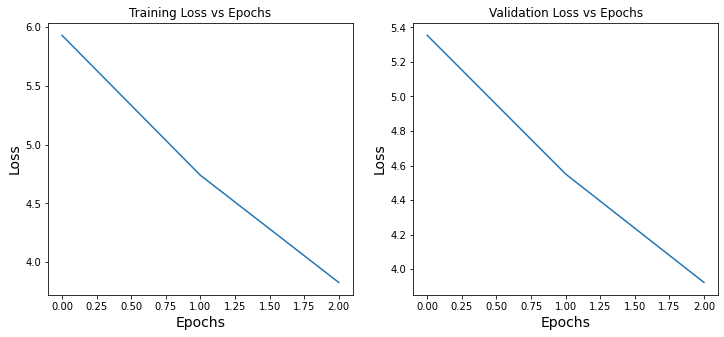

In [88]:
# Plot the learning curves for loss vs epoch for both training and validation sets.
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Training Loss vs Epochs')
axes[0].plot(epoch_train_loss)

axes[1].set_title('Validation Loss vs Epochs')
axes[1].set_ylabel("Loss", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(epoch_val_loss)
plt.show()

## 7. Use the model to translate
run the translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [89]:
#define the tokens 
start_token = tf.constant([[1]])
end_token = tf.constant([[2]])
end_token_val = end_token.numpy()[0][0]
#get index to word dictionary 
index_to_word = tokenizer.index_word

random_indexes = np.random.choice(len(english_sentences), 5)
for idx, e_idx in enumerate(random_indexes):
  curr_eng_sentence = english_sentences[e_idx]
  print(f"Sample: {idx}")
  print(f"English Sentence: {curr_eng_sentence}")
  split_eng_sentence = tf.strings.split(curr_eng_sentence, sep=' ')
  embedding_out = embedding_layer(split_eng_sentence)
  pad_value = tf.constant([[13,0], [0,0]])
  embeded_english_padded = tf.pad(embedding_out, pad_value) 
  embeded_english_padded_out = embeded_english_padded[-13:,:]
  
  
  embedding_exp = tf.expand_dims(embeded_english_padded_out, 0)
  hidden, cell_state = encoder_model(embedding_exp)
  translated_german = []
  decoder_input = start_token
  # keep making predictions until we find the end token
  while decoder_input.numpy()[0][0] != end_token_val: 
    # run through the decoder
    decoder_out, hidden, cell_state = decoder_model(decoder_input, 
                                                    hidden,
                                                    cell_state)
    # get the predicted index 
    pred_out_idx = ((np.argmax(decoder_out, axis=-1))[0][0])
    print(f"pred_out_idx: {pred_out_idx}")
    # if pred_out_idx == 0:
    #   break
    #translate to german word 
    german_word = index_to_word[pred_out_idx]
    #add to list 
    translated_german.append(german_word)
    #update decoder input 
    decoder_input = tf.constant([[pred_out_idx]])
  print(f"Original German: {german_sentences[e_idx]}")
  print(f"Trainslated German: {translated_german}")


Sample: 0
English Sentence: tom is thirtyish
pred_out_idx: 6
pred_out_idx: 5
pred_out_idx: 9
pred_out_idx: 95
pred_out_idx: 2
Original German: <start> tom ist um die dreissig <end>
Trainslated German: ['sie', 'ist', 'nicht', 'beschaeftigt', '<end>']
Sample: 1
English Sentence: everyone looked
pred_out_idx: 6
pred_out_idx: 5
pred_out_idx: 9
pred_out_idx: 95
pred_out_idx: 2
Original German: <start> alle schauten <end>
Trainslated German: ['sie', 'ist', 'nicht', 'beschaeftigt', '<end>']
Sample: 2
English Sentence: no one knows
pred_out_idx: 6
pred_out_idx: 5
pred_out_idx: 9
pred_out_idx: 95
pred_out_idx: 2
Original German: <start> das weiss niemand <end>
Trainslated German: ['sie', 'ist', 'nicht', 'beschaeftigt', '<end>']
Sample: 3
English Sentence: my brain is full
pred_out_idx: 6
pred_out_idx: 5
pred_out_idx: 9
pred_out_idx: 95
pred_out_idx: 2
Original German: <start> mein kopf ist voll <end>
Trainslated German: ['sie', 'ist', 'nicht', 'beschaeftigt', '<end>']
Sample: 4
English Sentence